##Problem Description
<p>In this project we have used a publicly available dataset from Kaggle. The dataset can be found at (https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). This is a facial expression recognition problem from images. The dataset contains a CSV file along with pixel values of 35887 images along with their class labels. There are 28,709 images for training, 3,589 examples for public testing and private test set consists of another 3,589 examples. Facial expression for these images can be of one of these seven classes (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). To solve this multiclass classification problem we have used three CNN architectures (LeNet-5, a modified version of LeNet and pretrained ResNet-50) with differet parameters. The model which generated the best test accuracy was deployed.

In [ ]:
#importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [ ]:
#mounting Google drive with Google colab to read and write data in the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#dataset is a CSV file. So reading the csv file using pandas library
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FER_Data/fer2013.csv')

In [ ]:
#showing data from first 10 rows of the csv file
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
#getting the location of the csv file in the variable file_name
file_name = '/content/drive/My Drive/Colab Notebooks/FER_Data/fer2013.csv'

In [ ]:
# creating four empty lists x, y, x_test and y_test
x = [] #for storing the training-set images
y = [] #for storing the corresponding labels of the training-set images
x_test = [] #for storing the test-set images
y_test = [] #for storing the corresponding test-set labels

count = 0
for line in open(file_name):
  if count == 0: #skipping the first row, which includes the column names
    count = 1
    continue
  else:
    row = line.split(',') #Row has three elements. The first one is the label, the second one is the image and the 3rd one is the Usage
    if row[2] == 'Training\n':
      x.append([int(i)/255 for i in row[1].split()]) #converting the pixel data type from string to integer and coverting the value in range [0 to 1]
      y.append(int(row[0])) #changing the data type of the label to integer and storing it in y
    elif row[2] == 'PublicTest\n': 
      x_test.append([int(i)/255 for i in row[1].split()])
      y_test.append(int(row[0]))

#converting to numpy arrays
y = np.array(y)
x = np.array(x)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
#function to convert the shape of the image from 2304 to 48x48
def im_reshp(x, x_test, x1):
  x = [i.reshape(x1,x1) for i in x]
  x = np.array(x)
  x_test = [i.reshape(x1,x1) for i in x_test]
  x_test = np.array(x_test)
  return x, x_test

In [ ]:
#calling the im_reshp function
x, x_test = im_reshp(x, x_test, 48)

In [ ]:
print("Size of train set: " + str(x.shape))
print("Size of test set: " + str(x_test.shape))

Size of train set: (28709, 48, 48)
Size of test set: (3589, 48, 48)


In [ ]:
# showing the number of images per label of the dataset
n_classes = len(np.unique(y))
for class_n in range(n_classes):
  class_indices = np.where(y == class_n)
  n_samples = len(class_indices[0])
  print(str(class_n) + ": " + str(n_samples)) 

0: 3995
1: 436
2: 4097
3: 7215
4: 4830
5: 3171
6: 4965


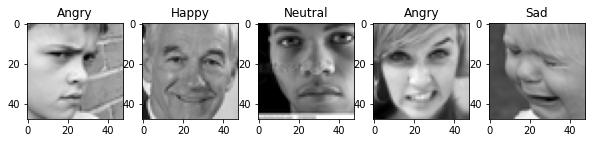

In [ ]:
import random
#dictionary containing the label and the corresponding facial expression
dicti = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
#taking 5 random integer values in range [0, 28709]
a = []
for i in range(5):
  a.append(random.randrange(0, x.shape[0], 1))
# showing five random images from the training-set and their corresponding facial expressions
fig, ax = plt.subplots(1, 5, figsize=(10,10))
for i in range(5):
  ax[i].imshow(x[a[i]], cmap='gray')
  ax[i].set_title(dicti.get(y[a[i]]))
  #print(dicti.get(y[a[i]]))

In [ ]:
#splitting the training set into train-set and validation-set randomly
def split_data(x,y):
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
  return x_train, x_val, y_train, y_val

In [ ]:
#architecture of the LeNet-5 model by Yann LeCun
def model_build_LeNet(input_shape, filters1, filters2, units1, units2, units3, ker_sz):
  #input layer
  input_layer = layers.Input((input_shape, input_shape, 1))

  #convolutional layer input shape -> (n, input_shape, input_shape) output from convolution layer has shape -> (n, floor((input_shape+2*padding-kernel)/stride + 1), floor((input_shape+2*padding-kernel)/stride)+1), number of filters) 
  conv_layer1 = layers.Conv2D(filters=filters1, kernel_size=(ker_sz, ker_sz), strides=(1, 1), activation='relu')(input_layer)
  
  #max-pooling layer output shape -> (n, (input_shape+(2*padding)-pool_size[0])/strides[0] + 1), (input_shape+(2*padding)-pool_size[1])/strides[1] + 1)
  pooling_layer1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)(conv_layer1)

  conv_layer2 = layers.Conv2D(filters=filters2, kernel_size=(ker_sz, ker_sz), strides=(1, 1), activation='relu')(pooling_layer1)
  pooling_layer2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)(conv_layer2)

  #flatten layer
  flatten_layer1 = layers.Flatten()(pooling_layer2)

  #Dense layer with output shape of (n, units1), n is the batch size
  Dense1 = layers.Dense(units=units1, activation='relu')(flatten_layer1)
  #dropping connections with a probability of 10%
  Droput1 = layers.Dropout(0.1)(Dense1)

  Dense2 = layers.Dense(units=units2, activation='relu')(Droput1)

  Droput2 = layers.Dropout(0.2)(Dense2)

  output_layer = layers.Dense(units=units3, activation = 'softmax')(Droput2)

  model = models.Model(inputs=input_layer, outputs=output_layer)

  return model

In [ ]:
#compiling the model with categorical cross-entropy loss and Adam optimizer with learning rate of 0.00025 and considering the accuracy as metrics of the model
def compile_model(model):
  model.compile(loss=losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=.00025), metrics=['accuracy'])

In [ ]:
#saving the weights of the epoch that generate the best validation accuracy
def save_weights(model_number):
  from tensorflow.keras.callbacks import ModelCheckpoint
  checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights' + str(model_number) + '.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
  return checkpoint

In [ ]:
#reduce learning rate with a factor of 0.25 if the validation accuracy does not improve for 3 epochs and the minimum learning rate can be 0.00005
def lr_reduce():
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, 
                                            factor=0.25, min_lr=0.00005)
  return learning_rate_reduction

In [ ]:
#training the model
def model_train(model, model_number, x, y):
  compile_model(model) #compile model
  learning_rate_reduction = lr_reduce()
  checkpoint = save_weights(model_number)
  x_train, x_val, y_train, y_val = split_data(x,y) #splitting the training data to training and validation data
  # calling the model.fit function where the whole data-set will be trained thirty times and batch size is 100.
  # to_categorical changes the list of y_train to a matrix i.e (n,1)->(n, # of labels)
  model.fit(x_train, to_categorical(y_train), epochs=30, validation_data=(x_val,to_categorical(y_val)), verbose = 1, callbacks=[learning_rate_reduction, checkpoint], batch_size=100)

In [ ]:
# original shape of images in the data-set is 48x48. So shrinking it to 32x32. As the original LeNet-5 architecture had input shape of nx32x32x1. n is the batch size.
import cv2
def image_resize_shrink(img, x1):
  re_img = []
  for i in img:
    re = cv2.resize(i, (x1,x1), interpolation=cv2.INTER_AREA)
    re_img.append(re)
  return re_img

In [ ]:
x_temp = np.array(image_resize_shrink(x, 32)) #changing the shape of x and storing it in x_temp
x_test_temp = np.array(image_resize_shrink(x_test, 32)) #changing the shape of x_test and storing it in x_test_temp

In [ ]:
model1 = model_build_LeNet(32, 6, 16, 120, 84, 7, 5) #calling the model_build_LeNet with the parameters used in the LeNet-5 paper
filters1, filters2, units1, units2, units3, ker_sz

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120 

In [ ]:
model_train(model1, 1, x_temp, y) #calling the model_train function and training the model. Here the model_number = 1 parameter ensures that the weight of this model is stored as a unique file.

Epoch 1/30
259/259 [==============================] - 31s 9ms/step - loss: 1.8453 - accuracy: 0.2328 - val_loss: 1.7446 - val_accuracy: 0.2825

Epoch 00001: val_accuracy improved from -inf to 0.28248, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights1.hdf5
Epoch 2/30
259/259 [==============================] - 2s 6ms/step - loss: 1.7355 - accuracy: 0.2997 - val_loss: 1.6608 - val_accuracy: 0.3546

Epoch 00002: val_accuracy improved from 0.28248 to 0.35458, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights1.hdf5
Epoch 3/30
259/259 [==============================] - 2s 6ms/step - loss: 1.6646 - accuracy: 0.3470 - val_loss: 1.6075 - val_accuracy: 0.3741

Epoch 00003: val_accuracy improved from 0.35458 to 0.37409, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights1.hdf5
Epoch 4/30
259/259 [==============================] - 2s 6ms/step - loss: 1.6228 - accu

In [ ]:
#returning the address of the saved weights of a particular model
def weight_add(model_number):
  return '/content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights' + str(model_number) + '.hdf5'

In [ ]:
#loading the weights of the model1 which generated the best validation accuracy
model1.load_weights(weight_add(1))

In [ ]:
#evaluating the model against the test set
model1.evaluate(x=x_test_temp, y=to_categorical(y_test))

113/113 [==============================] - 0s 4ms/step - loss: 1.3263 - accuracy: 0.4890


[1.326271653175354, 0.48899415135383606]

In [ ]:
#modimied LeNet architecture according to the paper by Pierre Sermanet and Yann LeCun published in 2011. Paper: Trafﬁc Sign Recognition with Multi-Scale Convolutional Networks
def model_build_LeNet_mod(input_shape, filters1, filters2, filters3, units1, units2, units3, ker_sz, padding):
  
  input_layer = layers.Input((input_shape, input_shape, 1))

  
  conv_layer1 = layers.Conv2D(filters=filters1, kernel_size=(ker_sz, ker_sz), padding = padding, strides=(1, 1), activation='relu')(input_layer)
  pooling_layer1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding= padding, data_format=None)(conv_layer1)

  conv_layer2 = layers.Conv2D(filters=filters2, kernel_size=(ker_sz, ker_sz), padding = padding, strides=(1, 1), activation='relu')(pooling_layer1)
  pooling_layer2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding=padding, data_format=None)(conv_layer2)

  flatten_layer2 = layers.Flatten()(pooling_layer2)

  conv_layer3 = layers.Conv2D(filters=filters3, kernel_size=(ker_sz, ker_sz), strides=(1, 1), activation='relu')(pooling_layer2)

  flatten_layer1 = layers.Flatten()(conv_layer3)

  # Modified LeNet has three convolutional layers. Output from the pooling_layer2 is flattened and then added with the flattened output of conv_layer3
  Concat = layers.concatenate([flatten_layer1, flatten_layer2])

  Dense1 = layers.Dense(units=units1, activation='relu')(Concat)

  Droput1 = layers.Dropout(0.1)(Dense1)

  Dense2 = layers.Dense(units=units2, activation='relu')(Droput1)

  Droput2 = layers.Dropout(0.2)(Dense2)

  output_layer = layers.Dense(units=units3, activation = 'softmax')(Droput2)

  model = models.Model(inputs=input_layer, outputs=output_layer)

  return model

In [ ]:
#model2 is the modified LeNet with the same parameters used in model1 except the 3rd cov layer has 400 hidden neurons
model2 = model_build_LeNet_mod(32, 6, 16, 400, 120, 84, 7, 5, 'valid')

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 6)    156         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 6)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 10, 16)   2416        max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [ ]:
model_train(model2, 2, x_temp, y)

Epoch 1/30
259/259 [==============================] - 3s 9ms/step - loss: 1.8392 - accuracy: 0.2383 - val_loss: 1.7276 - val_accuracy: 0.2982

Epoch 00001: val_accuracy improved from -inf to 0.29815, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights2.hdf5
Epoch 2/30
259/259 [==============================] - 2s 8ms/step - loss: 1.7126 - accuracy: 0.3217 - val_loss: 1.6440 - val_accuracy: 0.3511

Epoch 00002: val_accuracy improved from 0.29815 to 0.35110, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights2.hdf5
Epoch 3/30
259/259 [==============================] - 2s 8ms/step - loss: 1.6504 - accuracy: 0.3545 - val_loss: 1.6156 - val_accuracy: 0.3682

Epoch 00003: val_accuracy improved from 0.35110 to 0.36816, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights2.hdf5
Epoch 4/30
259/259 [==============================] - 2s 8ms/step - loss: 1.6061 - accur

In [ ]:
model2.load_weights(weight_add(2))

In [ ]:
model2.evaluate(x=x_test_temp, y=to_categorical(y_test))

113/113 [==============================] - 0s 4ms/step - loss: 1.3474 - accuracy: 0.4982


[1.3474482297897339, 0.49818891286849976]

In [ ]:
#model3 is the modified LeNet architecture with different parametr values. 
#Input shape is nx32x32x1, 32, 128 & 256 filters in the 1st, 2nd and 3rd conv layers. 256, 64 and 7 denotes the output shape of the 1st, 2nd and 3rd dense layers respectively.
# 7 output numbers are generated from the last dense layer as there are 7 labels in the dataset.
model3 = model_build_LeNet_mod(32, 32, 128, 256, 256, 64, 7, 3, 'same')

In [ ]:
model3.summary() 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 128)  36992       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [ ]:
model_train(model3, 3, x_temp, y)

Epoch 1/30
259/259 [==============================] - 7s 22ms/step - loss: 1.8131 - accuracy: 0.2500 - val_loss: 1.6065 - val_accuracy: 0.3821

Epoch 00001: val_accuracy improved from -inf to 0.38210, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights3.hdf5
Epoch 2/30
259/259 [==============================] - 5s 20ms/step - loss: 1.6035 - accuracy: 0.3832 - val_loss: 1.5162 - val_accuracy: 0.4183

Epoch 00002: val_accuracy improved from 0.38210 to 0.41832, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights3.hdf5
Epoch 3/30
259/259 [==============================] - 5s 20ms/step - loss: 1.5094 - accuracy: 0.4188 - val_loss: 1.4356 - val_accuracy: 0.4389

Epoch 00003: val_accuracy improved from 0.41832 to 0.43887, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights3.hdf5
Epoch 4/30
259/259 [==============================] - 5s 20ms/step - loss: 1.4415 - a

In [ ]:
model3.load_weights(weight_add(3))

In [ ]:
model3.evaluate(x=x_test_temp, y=to_categorical(y_test))

113/113 [==============================] - 1s 7ms/step - loss: 1.6764 - accuracy: 0.5676


[1.6763768196105957, 0.5675675868988037]

In [ ]:
#Function to resize image using Bicubic Interpolation.
import cv2
def image_resize_expand(img, x1):
  re_img = []
  for i in img:
    re = cv2.resize(i, (x1,x1), interpolation=cv2.INTER_CUBIC)
    re_img.append(re)
  return re_img

In [ ]:
x_temp = x
x_test_temp = x_test

In [ ]:
#model4 is the modified LeNet architecture with different parametr values. 
#Input shape is nx48x48x1, 32, 128 & 256 filters in the 1st, 2nd and 3rd conv layers. 256, 64 and 7 denotes the output shape of the 1st, 2nd and 3rd dense layers respectively.
# 7 output numbers are generated from the last dense layer as there are 7 labels in the dataset.
# padding is valid.
model4 = model_build_LeNet_mod(48, 32, 128, 256, 256, 64, 7, 3, 'valid')

In [ ]:
model4.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 46, 46, 32)   320         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 23, 23, 32)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 21, 21, 128)  36992       max_pooling2d_22[0][0]           
___________________________________________________________________________________________

In [ ]:
model_train(model4, 4, x_temp, y)

Epoch 1/30
259/259 [==============================] - 5s 18ms/step - loss: 1.7905 - accuracy: 0.2735 - val_loss: 1.5521 - val_accuracy: 0.4121

Epoch 00001: val_accuracy improved from -inf to 0.41205, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights4.hdf5
Epoch 2/30
259/259 [==============================] - 4s 15ms/step - loss: 1.5483 - accuracy: 0.4071 - val_loss: 1.4181 - val_accuracy: 0.4563

Epoch 00002: val_accuracy improved from 0.41205 to 0.45629, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights4.hdf5
Epoch 3/30
259/259 [==============================] - 4s 15ms/step - loss: 1.4123 - accuracy: 0.4671 - val_loss: 1.3768 - val_accuracy: 0.4716

Epoch 00003: val_accuracy improved from 0.45629 to 0.47161, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights4.hdf5
Epoch 4/30
259/259 [==============================] - 4s 16ms/step - loss: 1.3388 - a

In [ ]:
model4.load_weights(weight_add(4))

In [ ]:
model4.evaluate(x=x_test_temp, y=to_categorical(y_test))

113/113 [==============================] - 0s 4ms/step - loss: 1.6965 - accuracy: 0.5890


[1.696519374847412, 0.5890220403671265]

In [ ]:
x_temp = np.array(image_resize_expand(x, 64))
x_test_temp = np.array(image_resize_expand(x_test, 64))

In [ ]:
# as accuracy of the model increased because of using image size of (48x48) than image size of (32x32), we are now using image size of (64x64) to see if it increases the accuracy of the model.
model5 = model_build_LeNet_mod(64, 64, 128, 256, 256, 64, 7, 3, 'valid')

In [ ]:
model5.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 62, 62, 64)   640         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 31, 31, 64)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 29, 29, 128)  73856       max_pooling2d_14[0][0]           
____________________________________________________________________________________________

In [ ]:
model_train(model5, 5, x_temp, y)

Epoch 1/30
259/259 [==============================] - 10s 35ms/step - loss: 1.7872 - accuracy: 0.2743 - val_loss: 1.5099 - val_accuracy: 0.4169

Epoch 00001: val_accuracy improved from -inf to 0.41693, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights5.hdf5
Epoch 2/30
259/259 [==============================] - 8s 32ms/step - loss: 1.4804 - accuracy: 0.4350 - val_loss: 1.3604 - val_accuracy: 0.4835

Epoch 00002: val_accuracy improved from 0.41693 to 0.48346, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights5.hdf5
Epoch 3/30
259/259 [==============================] - 8s 33ms/step - loss: 1.3414 - accuracy: 0.4964 - val_loss: 1.2638 - val_accuracy: 0.5176

Epoch 00003: val_accuracy improved from 0.48346 to 0.51759, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights5.hdf5
Epoch 4/30
259/259 [==============================] - 9s 33ms/step - loss: 1.2419 - 

In [ ]:
model5.load_weights(weight_add(5))

In [ ]:
model5.evaluate(x=x_test_temp, y=to_categorical(y_test))

113/113 [==============================] - 1s 6ms/step - loss: 1.6718 - accuracy: 0.5731


[1.6718212366104126, 0.5731401443481445]

In [ ]:
x_temp = x
x_test_temp = x_test

In [ ]:
# We will now use ResNet-50 model to see if it increases the accuracy. ResNet-50 architecture acceptes image with 3 channels. 
#So changing the the channel number from 1 to 3 for the images of the dataset.
def im_resize(x, sz):
  batch_size = x.shape[0]
  X = np.empty((batch_size,) + (sz, sz, 3))
  for batch_idx in range(batch_size):
    for i in range(3):
      X[batch_idx,:,:,i] = x[batch_idx]
  return X


In [ ]:
x_temp = np.array(im_resize(x_temp, 48)) #x_temp is now of shape (48x48x3)
x_test_temp = np.array(im_resize(x_test_temp, 48))

In [ ]:
import tensorflow.keras.applications as app

In [ ]:
# We are taking a pretrained ResNet-50 model on imagenet dataset. We are excluding the last dense layers and will train these dense layers only.
# The rest of the model won't be trained.
def resnet_model1(sz):
  resnet = app.ResNet50(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
  output = resnet.layers[-1].output
  output = keras.layers.Flatten()(output)
  resnet = models.Model(inputs = resnet.input, outputs = output)
  for layer in resnet.layers:
      layer.trainable = False
  return resnet

In [ ]:
#adding three dense layers with the ouput of resnet_model1 
def resnet_model2(sz):
  resnet = resnet_model1(sz)
  model = models.Sequential()
  model.add(resnet)
  #model3.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(7, activation='softmax'))
  return model

In [ ]:
model6 = resnet_model2(48)

In [ ]:
#Total number of parameters is huge but we are only training a short number from the total parameters.
model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 8192)              23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 903       
Total params: 25,718,919
Trainable params: 2,131,207
Non-trainable params: 23,587,712
____________________________________

In [ ]:
# accuracy of the validation set is increasing frequently with the passing of epochs. Validation accuracy might increase if the
#model is trained for more epochs.
model_train(model6, 6, x_temp, y)

Epoch 1/30
259/259 [==============================] - 46s 39ms/step - loss: 1.9347 - accuracy: 0.2103 - val_loss: 1.7845 - val_accuracy: 0.2602

Epoch 00001: val_accuracy improved from -inf to 0.26019, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights6.hdf5
Epoch 2/30
259/259 [==============================] - 8s 31ms/step - loss: 1.8161 - accuracy: 0.2390 - val_loss: 1.7715 - val_accuracy: 0.2630

Epoch 00002: val_accuracy improved from 0.26019 to 0.26297, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights6.hdf5
Epoch 3/30
259/259 [==============================] - 8s 33ms/step - loss: 1.7908 - accuracy: 0.2514 - val_loss: 1.7653 - val_accuracy: 0.2783

Epoch 00003: val_accuracy improved from 0.26297 to 0.27830, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights6.hdf5
Epoch 4/30
259/259 [==============================] - 8s 32ms/step - loss: 1.7722 - 

In [ ]:
model6.load_weights(weight_add(6))

In [ ]:
#1.644 is the test loss and 0.3513 is the test accuracy
model6.evaluate(x=x_test_temp, y=to_categorical(y_test))

113/113 [==============================] - 36s 19ms/step - loss: 1.6419 - accuracy: 0.3595


[1.6441015005111694, 0.3513513505458832]

In [ ]:
#we now want to check if increasing the size of the images increase the accuracy of ResNet-50 model
x_temp = np.array(image_resize_expand(x, 64)) #x_temp has shape of (64x64)
x_test_temp = np.array(image_resize_expand(x_test, 64))

In [ ]:
x_temp = np.array(im_resize(x_temp, 64)) #x_temp has shape of (64x64x3)
x_test_temp = np.array(im_resize(x_test_temp, 64))

In [ ]:
model7 = resnet_model2(64) #model7 is the ResNet-50 architecture with input shape of nx64x64x3  

In [ ]:
model7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Functional)         (None, 8192)              23587712  
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 903       
Total params: 25,718,919
Trainable params: 2,131,207
Non-trainable params: 23,587,712
__________________________________

In [ ]:
model_train(model7, 7, x_temp, y)

Epoch 1/30
259/259 [==============================] - 48s 49ms/step - loss: 1.8914 - accuracy: 0.2143 - val_loss: 1.7940 - val_accuracy: 0.2640

Epoch 00001: val_accuracy improved from -inf to 0.26402, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights7.hdf5
Epoch 2/30
259/259 [==============================] - 11s 41ms/step - loss: 1.8011 - accuracy: 0.2520 - val_loss: 1.7633 - val_accuracy: 0.2679

Epoch 00002: val_accuracy improved from 0.26402 to 0.26785, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights7.hdf5
Epoch 3/30
259/259 [==============================] - 11s 41ms/step - loss: 1.7783 - accuracy: 0.2671 - val_loss: 1.7391 - val_accuracy: 0.2929

Epoch 00003: val_accuracy improved from 0.26785 to 0.29293, saving model to /content/drive/My Drive/Colab Notebooks/weights/FER_model_weights/lenet_weights7.hdf5
Epoch 4/30
259/259 [==============================] - 11s 42ms/step - loss: 1.7624

In [ ]:
model7.load_weights(weight_add(7))

In [ ]:
#increasing the input size of the images increased the testing accuracy by 2%. So it might be possible that increasing the
#size of the images more will also increase the accuracy of the model. As there are many convolutional layers in the model, using 
#a larger image resolution may increase the accuracy of the model. Due to lack of computation resources we have used a smaller image 
#resolution of 64x64.
model7.evaluate(x=x_test_temp, y=to_categorical(y_test))

113/113 [==============================] - 3s 23ms/step - loss: 1.6082 - accuracy: 0.3697


[1.608173131942749, 0.36974087357521057]

In [ ]:
# We have used total 7 models.
# model1 is the LeNet-5 with the same parameters used in the LeNet-5 paper. This gave a validation accuracy of 0.4953 and test accuracy of 0.4890
# model2 is the modified LeNet-5 with the same parameters used in the LeNet-5 paper with an extra conv layer. This model gave a validation accuracy of 0.5050 and test accuracy of 0.4981.
# model3 is the modified LeNet-5 with the different parameters as described before. This gave a validation accuracy of 0.5646 and test accuracy of 0.5676.
# model4 is the modified LeNet-5 with input shape of (n, 48,48,1). This produced the best validation and test accuracy (0.5855 and 0.5890 respectively).
# using a shape of (n, 64, 64, 1) decreased the accuracy of the model5 than model4.
# we have used padding = 'same' for model4 and model5, which generated testing accuracy of 0.5779 and 0.5637 respectively. We got better accuracy when we used padding = 'valid' for these models.
# model6 and model7 are ResNet-50 architecture with different input shapes.

GitHub repository of the project: https://github.com/ShawkhIbneRashid/Facial-expression-classifier-and-model-deployment